# Think Bayes

Copyright 2018 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [60]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import pandas as pd

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite, Joint

from thinkbayes2 import MakePoissonPmf, EvalBinomialPmf, MakeMixture, EvalPoissonPmf, MakeJoint

import thinkplot

## The Geiger counter problem

I got the idea for the following problem from Tom Campbell-Ricketts, author of the [Maximum Entropy blog](http://maximum-entropy-blog.blogspot.com). And he got the idea from E. T. Jaynes, author of the classic *Probability Theory: The Logic of Science*:

> Suppose that a radioactive source emits particles toward a Geiger counter at an average rate of r particles per second, but the counter only registers a fraction, f, of the particles that hit it. If f is 10% and the counter registers 15 particles in a one second interval, what is the posterior distribution of n, the actual number of particles that hit the counter, and r, the average rate particles are emitted?





### Grid algorithm



In [2]:
class Logistic(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        
        data: k, number of particles detected
        hypo: r, emission rate in particles per second
        """
        return 1

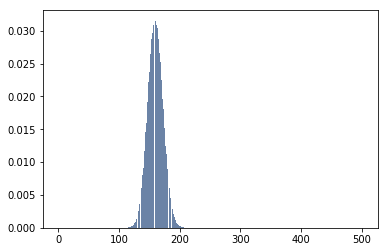

In [3]:
r = 160
k = 15
f = 0.1

pmf = MakePoissonPmf(r, high=500)
thinkplot.Hist(pmf)

In [4]:
total = 0
for n, p in pmf.Items():
    total += p * EvalBinomialPmf(k, n, f)
    
total

0.09921753162215896

In [5]:
def compute_likelihood(k, r, f):
    pmf = MakePoissonPmf(r, high=500)
    total = 0
    for n, p in pmf.Items():
        total += p * EvalBinomialPmf(k, n, f)
    
    return total

In [6]:
compute_likelihood(k, r, f)

0.09921753162215896

In [7]:
likes = pd.Series([])
for kk in range(0, 40):
    likes[kk] = compute_likelihood(kk, r, f)

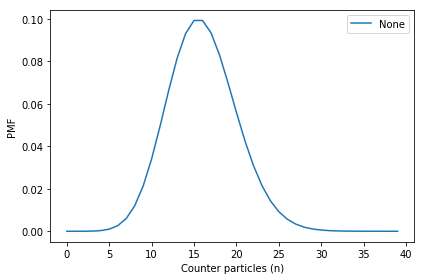

In [8]:
likes.plot()
thinkplot.decorate(xlabel='Counter particles (n)',
                   ylabel='PMF')

In [9]:
# Solution

class Logistic(Suite, Joint):
    f = 0.1
    
    def Likelihood(self, data, hypo):
        """
        
        data: k, number of particles detected
        hypo: r, emission rate in particles per second

        """
        k = data
        r = hypo
        return compute_likelihood(k, r, self.f)

In [10]:
rs = np.linspace(0, 300, 51);

In [11]:
suite = Logistic(rs);

In [12]:
suite.Update(15)

0.03262565933783285

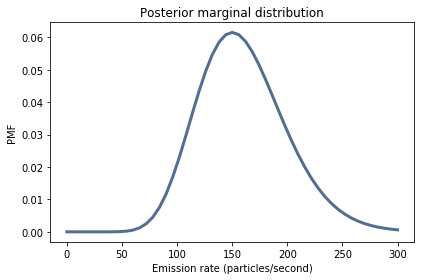

In [13]:
thinkplot.Pdf(suite)
thinkplot.decorate(xlabel='Emission rate (particles/second)',
                   ylabel='PMF',
                   title='Posterior marginal distribution')

### MCMC

Implement this model using MCMC.  As a starting place, you can use this example from [the PyMC3 docs](https://docs.pymc.io/notebooks/GLM-logistic.html#The-model).

As a challege, try writing the model more explicitly, rather than using the GLM module.

In [14]:
import pymc3 as pm

/home/eric/miniconda3/envs/ThinkBayes2/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [40]:
# Solution

f = 0.1
model = pm.Model()

with model:
    r = pm.Uniform('r', 0, 500)
    n = pm.Poisson('n', r)
    k = pm.Binomial('k', n, f, observed=15)
    trace = pm.sample_prior_predictive(1000)

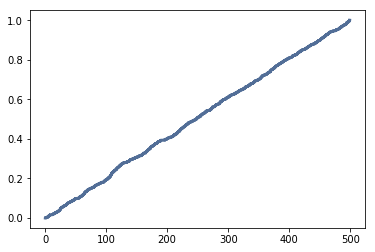

In [41]:
thinkplot.Cdf(Cdf(trace['r']));

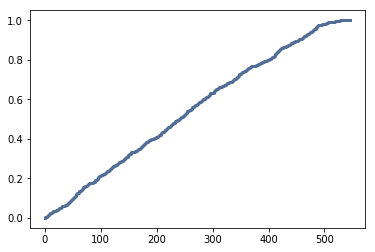

In [42]:
thinkplot.Cdf(Cdf(trace['n']));

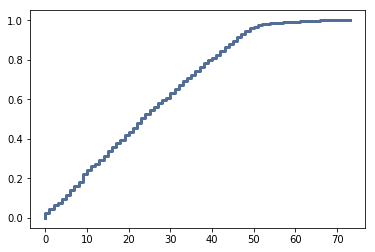

In [43]:
thinkplot.Cdf(Cdf(trace['k']));

In [46]:
with model:
    trace = pm.sample(4000, tune=3000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [r]
>Metropolis: [n]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:08<00:00, 1725.82draws/s]
The acceptance probability does not match the target. It is 0.35275809440619665, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8813223709491937, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


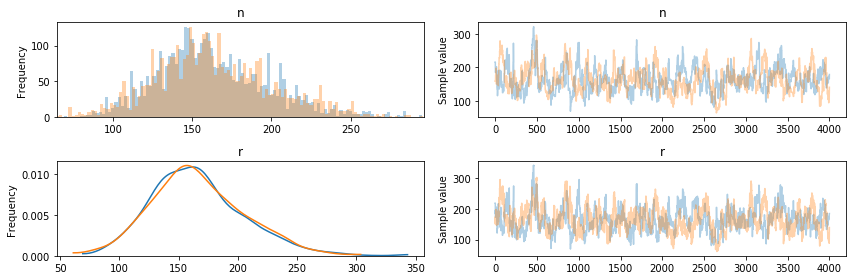

In [47]:
pm.traceplot(trace);

{'xscale': 'linear', 'yscale': 'linear'}

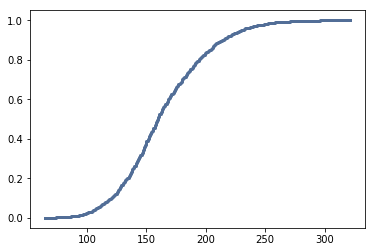

In [51]:
n_sample = trace['n']
thinkplot.Cdf(Cdf(n_sample))

{'xscale': 'linear', 'yscale': 'linear'}

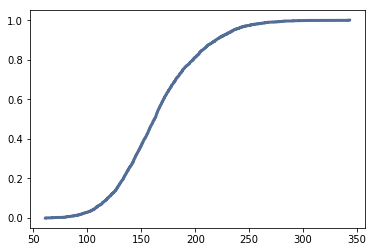

In [52]:
r_sample = trace['r']
thinkplot.Cdf(Cdf(r_sample))

In [53]:
thinkplot.Cdf(suite.MakeCdf())
thinkplot.Cdf(Cdf(r_sample))

TypeError: '<' not supported between instances of 'Detector' and 'Detector'

### Grid algorithm, version 2

In [24]:
# Solution

class Logistic(Suite, Joint):
    f = 0.1
    
    def Likelihood(self, data, hypo):
        """
        
        data: k, number of particles detected
        hypo: r, n
        """
        k = data
        r, n = hypo
        return EvalBinomialPmf(k, n, self.f)

In [25]:
rs = np.linspace(0, 300, 51);

In [26]:
suite = Logistic()

for r in rs:
    pmf = MakePoissonPmf(r, high=500)
    for n, p in pmf.Items():
        suite[r, n] += p
        
suite.Normalize()

50.99999999999964

In [27]:
suite.Update(15)

0.03262565933783306

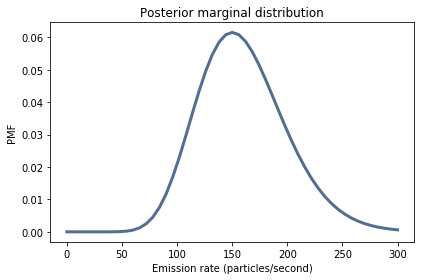

In [28]:
pmf_r = suite.Marginal(0)
thinkplot.Pdf(pmf_r)
thinkplot.decorate(xlabel='Emission rate (particles/second)',
                   ylabel='PMF',
                   title='Posterior marginal distribution')

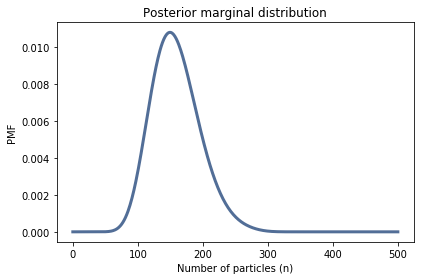

In [29]:
pmf_n = suite.Marginal(1)
thinkplot.Pdf(pmf_n)
thinkplot.decorate(xlabel='Number of particles (n)',
                   ylabel='PMF',
                   title='Posterior marginal distribution')

### Grid algorithm, Bayesian Prior version

In [61]:
# Solution

class Logistic(Suite, Joint):
    f = 0.1
    
    def Likelihood(self, data, hypo):
        """
        
        data: either (k, number of particles detected) or None, representing "prior" evidence
        hypo: r, n
        """
        r, n = hypo
        if data is None:
            return EvalPoissonPmf(n, r)
        
        k = data
        return EvalBinomialPmf(k, n, self.f)

In [62]:
rs = np.linspace(0, 300, 51);

In [63]:
suite = Logistic(MakeJoint(Pmf(rs), Pmf(range(500))))

suite.Update(None)

suite.Normalize()

0.9999999999999984

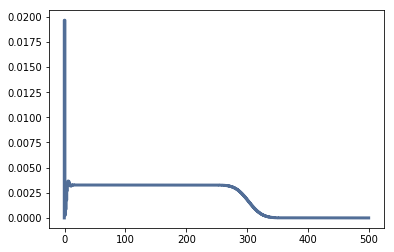

In [66]:
thinkplot.Pmf(suite.Marginal(1))

In [27]:
suite.Update(15)

0.03262565933783306

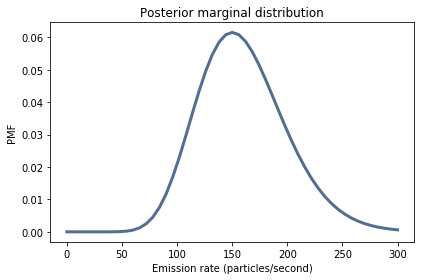

In [28]:
pmf_r = suite.Marginal(0)
thinkplot.Pdf(pmf_r)
thinkplot.decorate(xlabel='Emission rate (particles/second)',
                   ylabel='PMF',
                   title='Posterior marginal distribution')

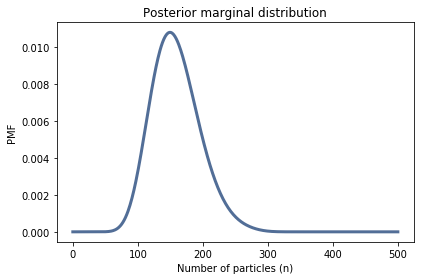

In [29]:
pmf_n = suite.Marginal(1)
thinkplot.Pdf(pmf_n)
thinkplot.decorate(xlabel='Number of particles (n)',
                   ylabel='PMF',
                   title='Posterior marginal distribution')

### Hierarchical version, as in the book

In [30]:
class Detector(Suite):
    """Represents hypotheses about n."""

    def __init__(self, r, f, high=500):
        """Initializes the suite.

        r: known emission rate, r
        f: fraction of particles registered
        high: maximum number of particles, n
        """
        pmf = MakePoissonPmf(r, high)
        super().__init__(pmf)
        self.r = r
        self.f = f

    def Likelihood(self, data, hypo):
        """Likelihood of the data given the hypothesis.

        data: number of particles counted
        hypo: number of particles hitting the counter, n
        """
        k = data
        n = hypo

        return EvalBinomialPmf(k, n, self.f)

In [31]:
r = 160
k = 15
f = 0.1

suite = Detector(r, f);

In [32]:
suite.Update(15)

0.09921753162215896

In [33]:
class Emitter(Suite):
    """Represents hypotheses about r."""

    def Likelihood(self, data, hypo):
        """Likelihood of the data given the hypothesis.

        data: number of counted per unit time
        hypo: Detector object
        """
        return hypo.Update(data)

In [34]:
rs = np.linspace(0, 300, 51);

In [35]:
detectors = [Detector(r, f=0.1) for r in rs[1:]]
suite = Emitter(detectors);

In [36]:
suite.Update(15)

0.03327817252458951

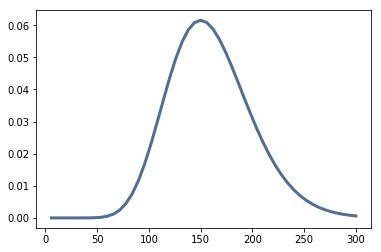

In [37]:
pmf_r = Pmf()
for detector, p in suite.Items():
    pmf_r[detector.r] = p
    
thinkplot.Pdf(pmf_r)

In [38]:
mix = MakeMixture(suite);

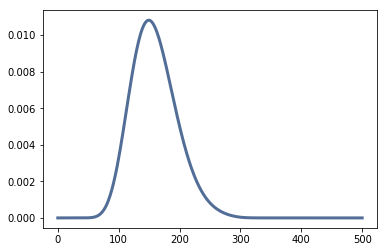

In [39]:
thinkplot.Pdf(mix)